In [ ]:
# The code was run in google colab. It needs to mount the drive firstly
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Process well data

In [ ]:
# read the private well records
df_wells = pd.read_csv('/content/drive/MyDrive/Vulnerable Wells/demo/data/pwts.csv', parse_dates=["dtSampled", "wellDateCompleted"], usecols=['vchWellNmbr', 'countyName', 'fLatitude', 'fLongitude', 'iWellDepth', 'wellDateCompleted', 'iWaterTestID', 'iWaterTestResultID', 'dtSampled', 'fResult', 'chResultDesignation', 'bPresent', 'analyte', 'vchMeasurementMethodDesc', 'vchSampleLoc', 'use_household'])
# filter to get the wells for household usage
df_wells = df_wells[df_wells['use_household'] == 1]

# get the nitrate test results
df_nitrate = df_wells.loc[df_wells['analyte']=='Nitrate', ['vchWellNmbr', 'countyName', 'fLatitude', 'fLongitude', 'iWellDepth', 'wellDateCompleted', 'iWaterTestID', 'iWaterTestResultID', 'dtSampled', 'fResult', 'chResultDesignation', 'analyte', 'vchMeasurementMethodDesc', 'vchSampleLoc', 'use_household']]

#### Drop invalid data

In [ ]:
# drop invalid coordinates
df_nitrate = df_nitrate.dropna(subset=['fLatitude', 'fLongitude'])
df_nitrate = df_nitrate[(df_nitrate['fLatitude'] >= 0) & (df_nitrate['fLatitude'] <= 90) & (df_nitrate['fLongitude'] >= -180) & (df_nitrate['fLongitude'] <= 0)]

# drop invalid test results (less than 0)
df_nitrate = df_nitrate[df_nitrate['fResult'] >= 0]
df_nitrate = df_nitrate.dropna(subset=['fResult'])

# drop record from December 12, 2013, to February 4, 2015 as the records accidentally increased during this period
# and drop the records after 2023-12-30
df_nitrate = df_nitrate.loc[(df_nitrate['dtSampled'] < '2013-12-12') | (df_nitrate['dtSampled'] > '2015-02-04') & (df_nitrate['dtSampled'] < '2023-12-30')]

#### Group year

In [ ]:
# check the sample date
group_by_result = df_nitrate.groupby(df_nitrate['dtSampled'].dt.year)['vchWellNmbr'].count()
group_by_result

In [ ]:
# filter year period
df_nitrate_year = df_nitrate[(df_nitrate['dtSampled'].dt.year >= 2004) & (df_nitrate['dtSampled'].dt.year <= 2018)]

#### Manipulate duplicated well records

In [ ]:
# find the duplicated well records
df_nitrate_year_group = df_nitrate_year.groupby('vchWellNmbr')['fResult']
df_nitrate_year_group.count().sort_values(ascending=False).head(10)

vchWellNmbr
2106448    52
2133418    49
2146681    48
2129236    46
2080309    34
2119627    33
2109711    31
2076234    30
2097147    30
2142745    30
Name: fResult, dtype: int64

In [ ]:
df_nitrate_year.sort_values('fResult', ascending=False)

,vchWellNmbr,countyName,fLatitude,fLongitude,iWellDepth,wellDateCompleted,iWaterTestID,iWaterTestResultID,dtSampled,fResult,chResultDesignation,analyte,vchMeasurementMethodDesc,vchSampleLoc,use_household
344855,2111875,MILLS,41.086200,-95.770800,267.0,1972-1-1 0:00,93078,243176,2014-06-30,1971.00,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchen sink,1.0
344864,2111875,MILLS,41.086200,-95.770800,267.0,1972-1-1 0:00,94159,246410,2014-07-29,1764.00,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchne sink,1.0
385528,2173476,POTTAWATTAMIE,41.384369,-95.815567,217.0,2014-3-25 0:00,92134,240483,2014-06-02,1692.00,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen tap,1.0
191902,2175173,DICKINSON,43.495403,-95.057896,15.0,1950-1-1 0:00,91776,239443,2014-05-07,1588.50,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Hydrant,1.0
34417,2176888,BOONE,42.005266,-94.041882,200.0,2000-1-1 0:00,93694,245017,2014-07-16,1460.43,NaN,Nitrate,NaN,outside,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460754,2161337,WRIGHT,42.832941,-93.604600,150.0,2004-1-1 0:00,108281,288991,2016-05-11,-1.00,NaN,Nitrate,NaN,Hydrant,1.0
462581,2189393,WRIGHT,42.644042,-93.962267,100.0,1965-1-1 0:00,108558,289865,2016-05-12,-1.00,NaN,Nitrate,NaN,Hydrant,1.0
363318,2160929,MONTGOMERY,41.030756,-95.068813,150.0,1952-1-1 0:00,91804,239526,2014-05-20,-4.50,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchen sink,1.0
363417,2173206,MONTGOMERY,41.102301,-95.051764,100.0,1955-1-1 0:00,89614,233045,2013-12-18,-4.50,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen sink,1.0


In [ ]:
# find the test results with drastic change
drastic_change = df_nitrate_year.groupby('vchWellNmbr')['fResult'].std().dropna().loc[lambda x: x > 50]
drastic_change

vchWellNmbr
2002217     64.862905
2011967     52.891587
2076774    189.779603
2079180    170.622145
2079703     65.122803
2086991     54.659354
2090662    113.802617
2092110     82.333070
2095067    133.718610
2096969    112.347915
2097178     53.892841
2097738     70.595719
2097760     63.709628
2098838    102.333295
2101074     53.384388
2101472     50.133871
2106448    134.804381
2107830     67.616640
2107858    123.351382
2108135     53.704180
2123420    188.645115
2123437     54.400081
2126676    489.168369
2126767     51.775930
2128799     55.154329
2132487     53.820179
2134312     53.047686
2134896     73.023166
2134924     54.345085
2136890     62.539666
2136896     81.945819
2137589     64.268150
2137623     60.575481
2137781     56.804245
2138139    104.337534
2138170     55.075762
2139402     72.831998
2141967    175.572331
2147103     53.245141
2147939     85.324218
2149795     56.725678
2149826     52.325902
2151189     67.332279
2152650     64.111015
2154055     69.01449

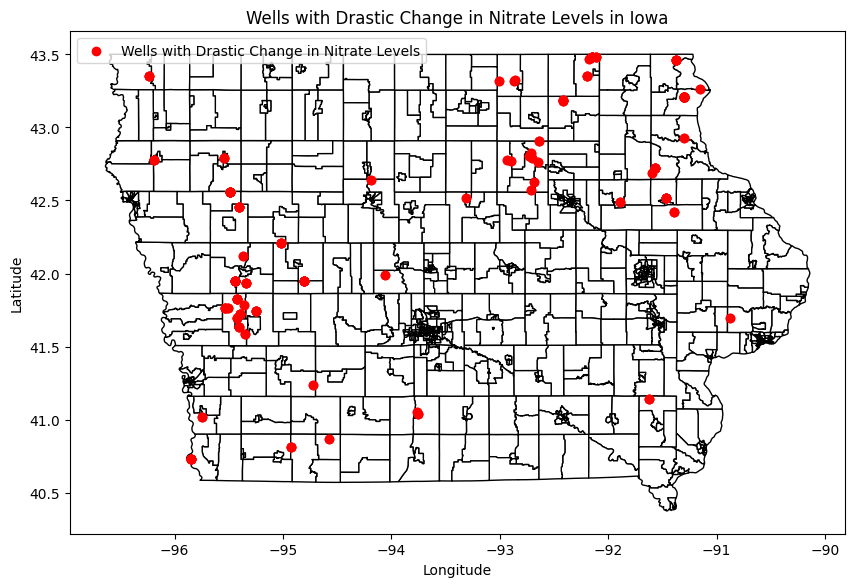

In [ ]:
# plot drastic_change nitrate results with the fLatitude and fLongitude on map.

import matplotlib.pyplot as plt

df_nitrate_drastic = df_nitrate_year[df_nitrate_year['vchWellNmbr'].isin(drastic_change.index)]
gdf_wells_drastic = gpd.GeoDataFrame(df_nitrate_drastic, geometry=gpd.points_from_xy(df_nitrate_drastic['fLongitude'], df_nitrate_drastic['fLatitude']), crs=4326)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_SVI.plot(ax=ax, facecolor='white', edgecolor='black')
gdf_wells_drastic.plot(ax=ax, marker='o', color='red', label='Wells with Drastic Change in Nitrate Levels')

ax.set_title('Wells with Drastic Change in Nitrate Levels in Iowa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()


In [ ]:
# calculate the standard deviation of fResult by vchWellNmbr
std_fResult = df_nitrate_year.groupby('vchWellNmbr')['fResult'].agg(np.std).dropna()
np.average(std_fResult)
# The result shows a medium variation of the general data

2.224132605472313

In [ ]:
# calculate means of the duplicate well test results
df_nitrate_year = df_nitrate_year.groupby('vchWellNmbr')['fResult'].mean().reset_index()
# df_nitrate_year.count()

# merge the wells' attributes and set the result as the means above
unique_df_nitrate = df_nitrate.drop_duplicates(subset='vchWellNmbr')
df_nitrate_year = df_nitrate_year.merge(unique_df_nitrate, how='left', on='vchWellNmbr')
df_nitrate_year['fResult']=df_nitrate_year['fResult_x']
df_nitrate_year=df_nitrate_year.drop(['fResult_x','fResult_y'], axis=1)

df_nitrate_year

,vchWellNmbr,countyName,fLatitude,fLongitude,iWellDepth,wellDateCompleted,iWaterTestID,iWaterTestResultID,dtSampled,chResultDesignation,analyte,vchMeasurementMethodDesc,vchSampleLoc,use_household,fResult
0,2000020,IDA,42.474153,-95.401304,390.0,1972-3-6 0:00,86831,225128,2012-08-08,NaN,Nitrate,ION CHROMATOGRAPHY,KS,1.0,12.000000
1,2000041,STORY,42.135914,-93.427637,238.0,1971-7-22 0:00,39021,93155,2006-09-18,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Cellar raw water sampling tap,1.0,0.200000
2,2000054,CLAYTON,42.811790,-91.236970,199.0,1970-3-11 0:00,42402,102354,2007-01-03,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Well,1.0,1.793333
3,2000062,SAC,42.422856,-95.057349,370.0,1972-6-30 0:00,75558,193362,2011-12-06,NaN,Nitrate,ION CHROMATOGRAPHY,Kitchen sink,1.0,0.800000
4,2000085,JONES,42.288745,-91.159761,150.0,1972-7-11 0:00,34923,81957,2006-05-01,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",KITCHEN SINK,1.0,3.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46546,2212376,SAC,42.271926,-95.041874,55.0,1950-1-1 0:00,162611,469896,2013-02-04,NaN,Nitrate,ION CHROMATOGRAPHY,kitchen sink,1.0,0.500000
46547,2219725,WEBSTER,42.255025,-94.359282,400.0,2015-7-8 0:00,159597,459567,2015-06-10,NaN,Nitrate,NaN,Spigot Southside of House,1.0,0.876222
46548,2221439,CERRO GORDO,43.008742,-93.328803,225.0,1989-4-1 0:00,162471,469459,1995-11-28,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",faucet,1.0,1.000000
46549,2223388,FAYETTE,42.681410,-91.705493,125.0,1977-5-2 0:00,166200,482098,2005-03-23,NaN,Nitrate,NaN,Kitchen faucet,1.0,0.222222


#### Select well depth

In [ ]:
df_nitrate_year = df_nitrate_year[df_nitrate_year['iWellDepth']<=100]
df_nitrate_year

,vchWellNmbr,countyName,fLatitude,fLongitude,iWellDepth,wellDateCompleted,iWaterTestID,iWaterTestResultID,dtSampled,chResultDesignation,analyte,vchMeasurementMethodDesc,vchSampleLoc,use_household,fResult
11,2000213,WORTH,43.429000,-93.260000,70.0,2001-9-17 0:00,39497,94476,2006-10-09,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen,1.0,0.200000
13,2000251,BREMER,42.669522,-92.482895,95.0,1971-7-14 0:00,30469,70055,2005-08-30,NaN,Nitrate,ION SELECTIVE ELECTRODE,kitchen sink,1.0,2.100000
33,2000398,CARROLL,42.047075,-94.925956,38.0,2001-6-19 0:00,36524,86287,2006-06-26,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen,1.0,3.039829
40,2000479,MILLS,40.972692,-95.743325,94.0,2001-5-1 0:00,28562,65073,2005-01-25,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Outside faucet,1.0,0.200000
42,2000489,POTTAWATTAMIE,41.274138,-95.614022,90.0,2001-7-10 0:00,15045,34463,2003-03-18,=,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen sink,1.0,10.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46542,2205192,MONTGOMERY,40.959877,-95.353315,100.0,2000-1-1 0:00,133989,371091,2018-11-07,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",bathroom sink,1.0,0.777778
46544,2209163,TAMA,42.130650,-92.720940,60.0,1979-1-1 0:00,143234,403916,2009-11-12,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchen Sink,1.0,0.622222
46545,2211351,MADISON,41.378861,-94.049170,37.0,1989-1-1 0:00,146136,414166,2004-08-31,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchen Sink,1.0,2.444444
46546,2212376,SAC,42.271926,-95.041874,55.0,1950-1-1 0:00,162611,469896,2013-02-04,NaN,Nitrate,ION CHROMATOGRAPHY,kitchen sink,1.0,0.500000


In [ ]:
df_nitrate_year['iWellDepth'].describe()

count    19048.000000
mean        67.163534
std         31.073352
min          1.000000
25%         40.000000
50%         75.000000
75%        100.000000
max        100.000000
Name: iWellDepth, dtype: float64

#### Convert to gdf

In [ ]:
# change the type of df_nitrate_year['dtSampled'] and df_nitrate_year['wellDateCompleted'] into string
df_nitrate_year['dtSampled'] = df_nitrate_year['dtSampled'].astype(str)
df_nitrate_year['wellDateCompleted'] = df_nitrate_year['wellDateCompleted'].astype(str)

In [ ]:
gdf_wells = gpd.GeoDataFrame(df_nitrate_year, geometry=gpd.points_from_xy(df_nitrate_year['fLongitude'], df_nitrate_year['fLatitude']), crs=4326)
# gdf_wells[pd.isna(gdf_wells['fLatitude'])]

In [ ]:
gdf_wells['dtSampled'] = pd.to_datetime(gdf_wells['dtSampled']).dt.strftime('%Y-%m-%d')
gdf_wells['wellDateCompleted'] = pd.to_datetime(gdf_wells['wellDateCompleted']).dt.strftime('%Y-%m-%d')

#### Clip with state boundary

In [ ]:
gdf_wells_5070 = gdf_wells.to_crs(5070)
# clip the gdf_wells by gdf_SVI, only keep the points inside the shape boundary of gdf_SVI
gdf_wells = gdf_wells.clip(gdf_SVI)
gdf_wells

,vchWellNmbr,countyName,fLatitude,fLongitude,iWellDepth,wellDateCompleted,iWaterTestID,iWaterTestResultID,dtSampled,chResultDesignation,analyte,vchMeasurementMethodDesc,vchSampleLoc,use_household,fResult,geometry
13969,2112510,LEE,40.431800,-91.395200,30.0,1980-1-1 0:00,30405,69906,2005-08-15,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen sink,1.0,0.200000,POINT (-91.39520 40.43180)
28859,2147576,LEE,40.431800,-91.395200,80.0,1970-1-1 0:00,65126,164392,2010-04-20,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",Kitchen Sink,1.0,0.444444,POINT (-91.39520 40.43180)
8368,2100750,LEE,40.456600,-91.391500,45.0,1974-1-6 0:00,20164,45865,2004-05-26,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",basement,1.0,1.550000,POINT (-91.39150 40.45660)
7609,2099064,LEE,40.457800,-91.446200,38.0,1950-1-1 0:00,18865,43032,2004-03-30,=,Nitrate,"CADMIUM REDUCTION, AUTOMATED",bathroom sink,1.0,8.400000,POINT (-91.44620 40.45780)
42697,2193875,LEE,40.470700,-91.381200,100.0,1950-1-1 0:00,115286,310190,2017-02-08,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",kitchen sink,1.0,0.222222,POINT (-91.38120 40.47070)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,2110859,MITCHELL,43.497400,-92.731700,100.0,2005-5-10 0:00,29085,66358,2005-05-11,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",BASEMENT,1.0,17.600000,POINT (-92.73170 43.49740)
5350,2091224,MITCHELL,43.499782,-92.753411,100.0,1950-1-1 0:00,12390,28319,2003-05-20,=,Nitrate,"CADMIUM REDUCTION, AUTOMATED",KITCHEN,1.0,0.200000,POINT (-92.75341 43.49978)
19490,2125053,MITCHELL,43.494400,-92.889800,100.0,2006-1-1 0:00,44909,109108,2006-12-01,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",k sink,1.0,3.500000,POINT (-92.88980 43.49440)
1065,2012856,MITCHELL,43.496742,-92.920291,53.0,1984-2-27 0:00,44376,107672,2007-02-02,NaN,Nitrate,"CADMIUM REDUCTION, AUTOMATED",k sink,1.0,1.300000,POINT (-92.92029 43.49674)


#### Export to shp

In [ ]:
# save the processed well result data
gdf_well_file = '/content/drive/MyDrive/Vulnerable Wells/demo/data2/nitrate_04_18.shp'
gdf_wells.to_file(gdf_well_file)
# gdf_wells = gpd.read_file(wells_file, crs=4326)

#### Interpolate point value to raster (Use Arcpy)

In [ ]:
import arcpy

arcpy.ImportToolbox(r"@\Spatial Analyst Tools.tbx")
arcpy.ga.EmpiricalBayesianKriging(
    in_features="nitrate_04_18_200_n0",
    z_field="fResult",
    out_ga_layer=None,
    out_raster=r"C:\Users\jinycai\OneDrive - University of Iowa\IOWA\VWells\project\ebk_04_18",
    cell_size=0.012400316,
    transformation_type="NONE",
    max_local_points=100,
    overlap_factor=1,
    number_semivariograms=100,
    search_neighborhood="NBRTYPE=StandardCircular RADIUS=1.78894316710331 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR",
    output_type="PREDICTION",
    quantile_value=0.5,
    threshold_type="EXCEED",
    probability_threshold=None,
    semivariogram_model_type="POWER"
)

#### Zone well results in raster to tracts

In [ ]:
!pip install rasterstats -q
!pip install rasterio -q
!pip install pygris -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 14.2 MB/s eta 0:00:00


In [ ]:
from rasterstats import zonal_stats
import rasterio
import matplotlib.pyplot as plt
import pygris

In [ ]:
default_crs = 'EPSG:4326'

# open the raster data
nitrate_14_18_ebk = rasterio.open('/content/drive/MyDrive/Vulnerable Wells/demo/data3/ebk_04_18')
nitrate_14_18_ebk_arr = nitrate_14_18_ebk.read(1)
affine=nitrate_14_18_ebk.transform

In [ ]:
# get the census tract shape
gdf_tract = pygris.tracts(state = "IA", year=2018, cb = True, cache = True)
gdf_tract.plot()

In [ ]:
# zonal stats
stats = zonal_stats(gdf_tract['geometry'], nitrate_14_18_ebk_arr, stats="std mean median", affine=affine)

# Join stats to gdf
df_stats = pd.DataFrame(stats)
df = pd.concat([gdf_tract, df_stats], axis=1)
gdf_tract_well = gpd.GeoDataFrame(df, geometry=df.geometry)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,mean,count,std,median
0,19,057,000200,1400000US19057000200,19057000200,2,CT,3321667,551388,"POLYGON ((-91.11504 40.82362, -91.11516 40.825...",7.004076,3,0.610862,6.851333
1,19,111,490900,1400000US19111490900,19111490900,4909,CT,1584814,2024047,"POLYGON ((-91.38949 40.43127, -91.37954 40.431...",4.876649,3,0.021019,4.870662
2,19,113,000901,1400000US19113000901,19113000901,9.01,CT,4923154,0,"POLYGON ((-91.70268 42.02860, -91.70164 42.030...",0.988715,3,0.042428,0.963138
3,19,113,002500,1400000US19113002500,19113002500,25,CT,2178284,0,"POLYGON ((-91.69271 41.95946, -91.69040 41.962...",2.053812,2,0.650648,2.053812
4,19,119,950100,1400000US19119950100,19119950100,9501,CT,514190984,12058,"POLYGON ((-96.09789 43.27922, -96.09662 43.346...",44.474185,361,16.372893,41.761585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,19,057,001100,1400000US19057001100,19057001100,11,CT,423092518,264904,"POLYGON ((-91.37170 40.92151, -91.37156 40.957...",1.019610,294,0.661627,0.867038
821,19,181,020100,1400000US19181020100,19181020100,201,CT,16750123,1872,"POLYGON ((-93.67428 41.51206, -93.65889 41.512...",4.291677,11,0.898969,4.363328
822,19,065,080100,1400000US19065080100,19065080100,801,CT,30453931,0,"POLYGON ((-91.84471 42.94982, -91.83915 42.949...",4.974365,19,1.813835,5.034451
823,19,089,960300,1400000US19089960300,19089960300,9603,CT,632254383,443003,"POLYGON ((-92.55442 43.30004, -92.55427 43.335...",5.980372,445,2.336610,5.947178


In [ ]:
gdf_tract_well = gdf_tract_well.rename(columns={"mean": "0418_nmean", "std": "0418_std", "median": "0418_median"})

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,0418_nmean,count,0418_std,0418_median
0,19,057,000200,1400000US19057000200,19057000200,2,CT,3321667,551388,"POLYGON ((-91.11504 40.82362, -91.11516 40.825...",7.004076,3,0.610862,6.851333
1,19,111,490900,1400000US19111490900,19111490900,4909,CT,1584814,2024047,"POLYGON ((-91.38949 40.43127, -91.37954 40.431...",4.876649,3,0.021019,4.870662
2,19,113,000901,1400000US19113000901,19113000901,9.01,CT,4923154,0,"POLYGON ((-91.70268 42.02860, -91.70164 42.030...",0.988715,3,0.042428,0.963138
3,19,113,002500,1400000US19113002500,19113002500,25,CT,2178284,0,"POLYGON ((-91.69271 41.95946, -91.69040 41.962...",2.053812,2,0.650648,2.053812
4,19,119,950100,1400000US19119950100,19119950100,9501,CT,514190984,12058,"POLYGON ((-96.09789 43.27922, -96.09662 43.346...",44.474185,361,16.372893,41.761585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,19,057,001100,1400000US19057001100,19057001100,11,CT,423092518,264904,"POLYGON ((-91.37170 40.92151, -91.37156 40.957...",1.019610,294,0.661627,0.867038
821,19,181,020100,1400000US19181020100,19181020100,201,CT,16750123,1872,"POLYGON ((-93.67428 41.51206, -93.65889 41.512...",4.291677,11,0.898969,4.363328
822,19,065,080100,1400000US19065080100,19065080100,801,CT,30453931,0,"POLYGON ((-91.84471 42.94982, -91.83915 42.949...",4.974365,19,1.813835,5.034451
823,19,089,960300,1400000US19089960300,19089960300,9603,CT,632254383,443003,"POLYGON ((-92.55442 43.30004, -92.55427 43.335...",5.980372,445,2.336610,5.947178


<Axes: >

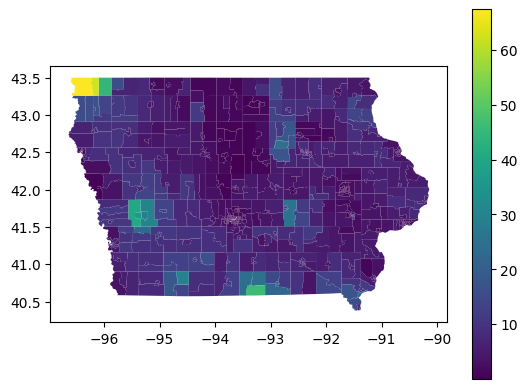

In [ ]:
gdf_tract_well.plot(column="0418_nmean", legend='true')

In [ ]:
gdf_tract_well.to_file('/content/drive/MyDrive/Vulnerable Wells/demo/data3/tract_well.shp', driver='ESRI Shapefile')

<ipython-input-126-7557748cae0c>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_tract_well.to_file('/content/drive/MyDrive/Vulnerable Wells/demo/data3/tract_well.shp', driver='ESRI Shapefile')


### Get geometry data

In [ ]:
!pip install pygris -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.5 MB/s eta 0:00:00


In [ ]:
import pygris

Using FIPS code '19' for input 'IA'


<Axes: >

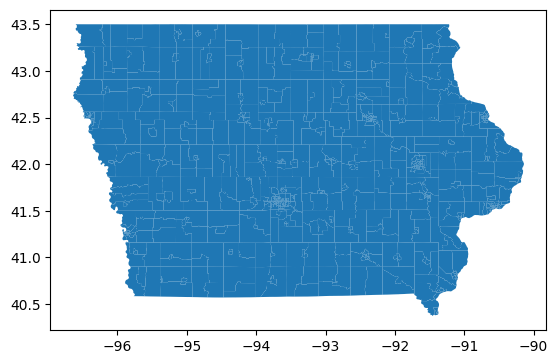

In [ ]:
# get the census tract shape
gdf_tract_18 = pygris.tracts(state = "IA", year=2018, cb = True, cache = True)
gdf_tract_18.plot()

### Process disease data

In [ ]:
import pandas as pd
import geopandas as gpd

In [ ]:
df_colorectal = pd.read_csv("/content/drive/MyDrive/Vulnerable Wells/demo/data2/disease/colorectal cancer incidence.csv")
# relationship file of ZCTA to census tract in 2010
df_zcta = pd.read_csv("/content/drive/MyDrive/Vulnerable Wells/demo/data2/disease/zcta_tract_rel_10.csv")
# relationship file of census tract from 2010 to 2020
df_tract20 = pd.read_csv("/content/drive/MyDrive/Vulnerable Wells/demo/data2/disease/tab20_tract20_tract10_natl.csv")

In [ ]:
df_colo_tract10

,ZCTA5,ZCTAs,cities,GEOID,09_13_rp,14_18_rp,04_08_rr,09_13_rr,14_18_rr
0,50841,50841,"""Corning""",19003950100,0.78,0.30,1.25,1.06,0.96
1,50841,50841,"""Corning""",19003950200,0.78,0.30,1.25,1.06,0.96
2,50841,50841,"""Corning""",19173180100,0.78,0.30,1.25,1.06,0.96
3,50841,50841,"""Corning""",19173180300,0.78,0.30,1.25,1.06,0.96
4,52162,52162,"""Postville""",19005960400,0.09,0.01,1.05,0.91,0.84
...,...,...,...,...,...,...,...,...,...
2776,50521,50521,"""Burnside""",19187010400,0.35,0.27,1.06,0.95,0.91
2777,51101,51101,"""Sioux City""",19193000100,0.85,0.82,1.14,1.12,1.12
2778,51101,51101,"""Sioux City""",19193001200,0.85,0.82,1.14,1.12,1.12
2779,51101,51101,"""Sioux City""",19193003600,0.85,0.82,1.14,1.12,1.12


In [ ]:
df_colorectal

,Unnamed: 0,09_13_rp,14_18_rp,04_08_rr,09_13_rr,14_18_rr,ZCTAs,cities
0,0.98,0.78,0.30,1.25,1.06,0.96,50841,"""Corning"""
1,0.63,0.09,0.01,1.05,0.91,0.84,52162,"""Postville"""
2,0.53,0.41,0.34,1.02,0.98,0.96,52572,"""Moulton"""
3,0.04,0.01,0.05,0.84,0.86,0.88,50014,"""Ames"""
4,0.92,0.58,0.19,1.19,1.02,0.94,50217,"""Paton"""
...,...,...,...,...,...,...,...,...
930,0.85.16,0.77,0.57,1.29,1.12,1.04,50165,"""Millerton"""
931,0.59.8,0.32,0.19,1.05,0.96,0.92,50523,"""Callender"""
932,0.52.10,0.35,0.27,1.06,0.95,0.91,50521,"""Burnside"""
933,0.75.13,0.85,0.82,1.14,1.12,1.12,51101,"""Sioux City"""


In [ ]:
df_colorectal['ZCTAs'] = df_colorectal['ZCTAs'].astype('int')

In [ ]:
# join all the columns in  df_colorectal to df_zcta based on the "ZCTAs" in df_colorectal and “ZCTA5” in df_zcta. only keep the columns of ZCTA5 and GEOID of df_zcta

df_colo_tract10 = pd.merge(df_colorectal, df_zcta, how='left', left_on='ZCTAs', right_on='ZCTA5')
df_colo_tract10 = df_colo_tract10[['ZCTA5', 'ZCTAs',	'cities', 'GEOID', '09_13_rp',	'14_18_rp',	'04_08_rr',	'09_13_rr',	'14_18_rr']]


In [ ]:
df_colo_tract10

,ZCTA5,ZCTAs,cities,GEOID,09_13_rp,14_18_rp,04_08_rr,09_13_rr,14_18_rr
0,50841,50841,"""Corning""",19003950100,0.78,0.30,1.25,1.06,0.96
1,50841,50841,"""Corning""",19003950200,0.78,0.30,1.25,1.06,0.96
2,50841,50841,"""Corning""",19173180100,0.78,0.30,1.25,1.06,0.96
3,50841,50841,"""Corning""",19173180300,0.78,0.30,1.25,1.06,0.96
4,52162,52162,"""Postville""",19005960400,0.09,0.01,1.05,0.91,0.84
...,...,...,...,...,...,...,...,...,...
2776,50521,50521,"""Burnside""",19187010400,0.35,0.27,1.06,0.95,0.91
2777,51101,51101,"""Sioux City""",19193000100,0.85,0.82,1.14,1.12,1.12
2778,51101,51101,"""Sioux City""",19193001200,0.85,0.82,1.14,1.12,1.12
2779,51101,51101,"""Sioux City""",19193003600,0.85,0.82,1.14,1.12,1.12


In [ ]:
gdf_tract['GEOID'] = gdf_tract['GEOID'].astype('int')
tract10_group = df_colo_tract10.groupby('GEOID')[['09_13_rp', '14_18_rp', '04_08_rr','09_13_rr', '14_18_rr']].agg('mean')
gdf_disease = gdf_tract.merge(tract10_group, on='GEOID', how='inner')
gdf_disease

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,09_13_rp,14_18_rp,04_08_rr,09_13_rr,14_18_rr
0,19,057,000200,1400000US19057000200,19057000200,2,CT,3321667,551388,"POLYGON ((-91.11504 40.82362, -91.11516 40.825...",0.340000,0.120,1.090000,0.980,0.930
1,19,111,490900,1400000US19111490900,19111490900,4909,CT,1584814,2024047,"POLYGON ((-91.38949 40.43127, -91.37954 40.431...",0.730000,0.490,1.150000,1.050,1.000
2,19,113,000901,1400000US19113000901,19113000901,9.01,CT,4923154,0,"POLYGON ((-91.70268 42.02860, -91.70164 42.030...",0.000000,0.000,0.930000,0.870,0.850
3,19,113,002500,1400000US19113002500,19113002500,25,CT,2178284,0,"POLYGON ((-91.69271 41.95946, -91.69040 41.962...",0.050000,0.030,0.990000,0.930,0.900
4,19,119,950100,1400000US19119950100,19119950100,9501,CT,514190984,12058,"POLYGON ((-96.09789 43.27922, -96.09662 43.346...",0.641667,0.315,1.211667,1.040,0.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,19,057,001100,1400000US19057001100,19057001100,11,CT,423092518,264904,"POLYGON ((-91.37170 40.92151, -91.37156 40.957...",0.593000,0.395,1.132000,1.030,0.983
821,19,181,020100,1400000US19181020100,19181020100,201,CT,16750123,1872,"POLYGON ((-93.67428 41.51206, -93.65889 41.512...",0.585000,0.560,1.035000,1.020,1.025
822,19,065,080100,1400000US19065080100,19065080100,801,CT,30453931,0,"POLYGON ((-91.84471 42.94982, -91.83915 42.949...",0.550000,0.150,1.200000,1.010,0.930
823,19,089,960300,1400000US19089960300,19089960300,9603,CT,632254383,443003,"POLYGON ((-92.55442 43.30004, -92.55427 43.335...",0.286000,0.072,1.154000,0.952,0.858


<Axes: >

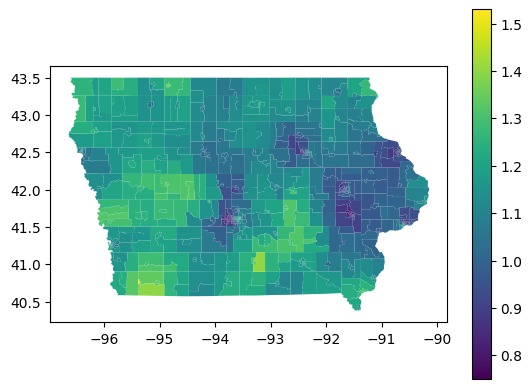

In [ ]:
gdf_disease.plot(column='04_08_rr', legend='true')

In [ ]:
# save the inci
gdf_disease.to_file('/content/drive/MyDrive/Vulnerable Wells/demo/data3/tract_disease.shp', driver='ESRI Shapefile')

### Process Population data

In [ ]:
!pip install census -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.3 MB/s eta 0:00:00


In [ ]:
from census import Census # Census library
import requests #allows APIcall to retrieve data

In [ ]:
# Declare connection variables to census API
API_KEY = '5f66ae8b0c4b7bcff7a83b0498867395c681e59b'

In [ ]:
ACS_variables = [['B01001_026E', 'B01002H_001E', 'B01003_001E',
       'B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_005E', 'B03002_006E',
       'B03002_012E', 'B06001_002E', 'B06007_001E', 'B06007_005E',
       'B06007_008E', 'B09020_001E', 'B16010_001E', 'B16010_002E',
       'B16010_041E', 'B17021_001E', 'B17021_002E', 'B19025_001E',
       'B19055_001E', 'B19055_002E', 'B23022_001E', 'B23022_025E',
       'B23022_049E', 'B25002_001E', 'B25002_002E', 'B25002_003E',
       'B25003_003E', 'B25008_001E', 'B25024_001E',
       ],['B25024_010E', 'B25106_001E', 'B25106_006E', 'B25106_010E',
       'B25106_014E', 'B25106_018E', 'B25106_022E', 'B25106_028E',
       'B25106_032E', 'B25106_036E', 'B25106_040E', 'B25106_044E',
       'B27001_001E', 'B27001_005E', 'B27001_008E', 'B27001_011E',
       'B27001_014E', 'B27001_017E', 'B27001_020E', 'B27001_023E',
       'B27001_026E', 'B27001_029E', 'B27001_033E', 'B27001_036E',
       'B27001_039E', 'B27001_042E', 'B27001_045E']]
Profile_variable = ['DP02_0071PE']

In [ ]:
# request details table variables in Iowa
df_ACS = pd.DataFrame()
for variables in ACS_variables:
  URL = "https://api.census.gov/data/2013/acs/acs5?get={0}&for=tract:*&in=state:19&key={1}".format("NAME," + ','.join(variables), API_KEY)
  response = requests.request("GET", URL)
  df_ACS_set= pd.DataFrame(response.json()[1:], columns = response.json()[0])
  df_ACS_set[variables] = df_ACS_set[variables].apply(pd.to_numeric)
  df_ACS_set['FIPS'] = df_ACS_set['state'] + df_ACS_set['county'] + df_ACS_set['tract']
  if df_ACS.shape[0] == 0:
    df_ACS = df_ACS_set
  else:
    df_ACS = df_ACS.merge(df_ACS_set[["FIPS"] + variables], on="FIPS", how="inner")

In [ ]:
# request profile table variables
URL = "https://api.census.gov/data/2013/acs/acs5/profile?get={0}&for=tract:*&in=state:19&key={1}".format(','.join(Profile_variable), API_KEY)
response = requests.request("GET", URL)
df_ACS_set= pd.DataFrame(response.json()[1:], columns = response.json()[0])
df_ACS_set[Profile_variable] = df_ACS_set[Profile_variable].apply(pd.to_numeric)
df_ACS_set['FIPS'] = df_ACS_set['state'] + df_ACS_set['county'] + df_ACS_set['tract']
df_ACS = df_ACS.merge(df_ACS_set[["FIPS"] + Profile_variable], on="FIPS", how="inner")

In [ ]:
# Read the selected senstivity variables into a Pandas DataFrame,
df = pd.read_csv('/content/drive/MyDrive/Vulnerable Wells/demo/data3/sensitivity variables.csv')

# Convert the DataFrame to a dictionary
population_dict = df.to_dict(orient='list')
population_dict

In [ ]:
# calculate the variables based on the algorithm
for field in population_dict['field']:
  algorithm = population_dict['algorithm'][population_dict['field'].index(field)]
  df_ACS["18_" + field] = df_ACS.eval(algorithm)
df_ACS.columns

Index(['NAME', 'B01001_026E', 'B01002H_001E', 'B01003_001E', 'B03002_001E',
       'B03002_004E', 'B03002_005E', 'B03002_006E', 'B03002_012E',
       'B06001_002E', 'B06007_001E', 'B06007_005E', 'B06007_008E',
       'B09020_001E', 'B16010_001E', 'B16010_002E', 'B16010_041E',
       'B17021_001E', 'B17021_002E', 'B19025_001E', 'B19055_001E',
       'B19055_002E', 'B23022_001E', 'B23022_025E', 'B23022_049E',
       'B25002_001E', 'B25002_002E', 'B25002_003E', 'B25003_003E',
       'B25008_001E', 'B25024_001E', 'state', 'county', 'tract', 'FIPS',
       'B25024_010E', 'B25106_001E', 'B25106_006E', 'B25106_010E',
       'B25106_014E', 'B25106_018E', 'B25106_022E', 'B25106_028E',
       'B25106_032E', 'B25106_036E', 'B25106_040E', 'B25106_044E',
       'B27001_001E', 'B27001_005E', 'B27001_008E', 'B27001_011E',
       'B27001_014E', 'B27001_017E', 'B27001_020E', 'B27001_023E',
       'B27001_026E', 'B27001_029E', 'B27001_033E', 'B27001_036E',
       'B27001_039E', 'B27001_042E', 'B27001_04

In [ ]:
field_18 = ['18_Total_POP', '18_QASIAN', '18_QBLACK', '18_QHISP', '18_QNATIVE',
       '18_QAGEDEP', '18_QPUNIT', '18_QRENTER', '18_QFEMALE', '18_QUNOCCHU',
       '18_QUNEMPLOY', '18_QPOVTY', '18_QMOHO', '18_QSSBEN', '18_PERCAP',
       '18_QHSEBURDEN', '18_QNOINSURED', '18_QESL', '18_QNOBD', '18_QED12LES']

In [ ]:
# merge the population data into Iowa census tract geographic data
gdf_population = gdf_tract.merge(df_ACS[['FIPS']+field_18], left_on="GEOID", right_on="FIPS", how="inner")

<Axes: >

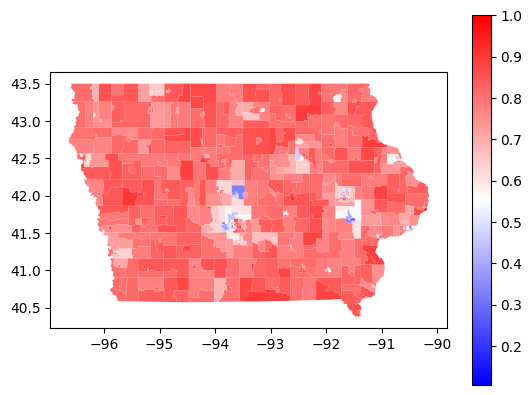

In [ ]:
gdf_population.plot(column='18_QNOBD', legend=True, cmap='bwr')

In [ ]:
# save the processed data
gdf_population.to_file('/content/drive/MyDrive/Vulnerable Wells/demo/data3/population_14_18.shp')

### Merge wells, population and disease data

In [ ]:
import geopandas as gpd
import pandas as pd

gdf_population = gpd.read_file("/content/drive/MyDrive/Vulnerable Wells/demo/data3/population_09_18.shp", crs=4326)
gdf_disease = gpd.read_file("/content/drive/MyDrive/Vulnerable Wells/demo/data3/tract_disease.shp", crs=4326)
gdf_tract_well = gpd.read_file("/content/drive/MyDrive/Vulnerable Wells/demo/data3/tract_well.shp", crs=4326)

In [ ]:
gdf_disease['GEOID'] = gdf_disease['GEOID'].astype(str)
gdf_tract_SVI = gdf_population.merge(gdf_disease[['GEOID', '09_13_rp', '14_18_rp', '04_08_rr','09_13_rr', '14_18_rr']], on='GEOID', how='inner')
gdf_tract_SVI = gdf_tract_SVI.merge(gdf_tract_well[['GEOID', '0418_nmean', '0418_std', '0418_media']], on='GEOID', how='inner')

<Axes: >

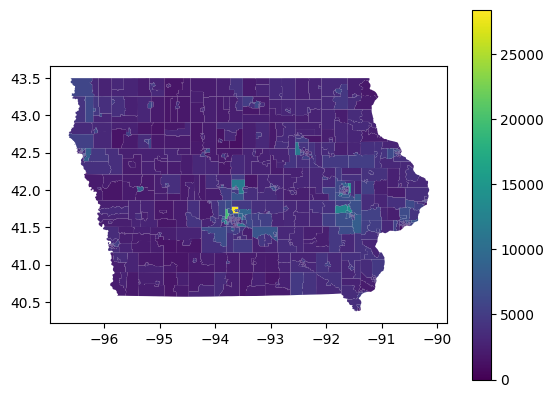

In [ ]:
gdf_tract_SVI.plot(column='18_Total_P', legend='true')

In [ ]:
# set all the NaN value in gdf_tract_SVI to 0
gdf_tract_SVI = gdf_tract_SVI.fillna(0)

In [ ]:
# Calculate areas and population density
gdf_tract_SVI_5070 = gdf_tract_SVI.to_crs(5070)
gdf_tract_SVI['area'] = gdf_tract_SVI_5070['geometry'].area/1000000
gdf_tract_SVI['18_POPDEN'] = gdf_tract_SVI['18_Total_P']/gdf_tract_SVI['area']

In [ ]:
gdf_SVI_4326 = gdf_tract_SVI.to_crs(4326)

In [ ]:
gdf_SVI_4326.to_file('/content/drive/MyDrive/Vulnerable Wells/demo/data3/0505/IA_SVI_tract_4326.shp')